**Regresión no lineal**

**Nombre:** Carlos Hernández Márquez

**Matrícula:** 653602

**Firma de honor:**
"Doy mi palabra que he realizado esta actividad con integridad académica"

# **Introduccion**

Con el objetivo de explorar modelos de regresión no lineal, se trabajará con una base de datos generada a partir del semestre de Otoño 2022 del curso Sistemas Digitales, impartido por el Dr. Antonio M. Torteya en la Universidad de Monterrey.

En esta materia, cada semana se entregan actividades cuya fecha límite es el domingo a medianoche. El conjunto de datos está conformado por 432 actividades entregadas (432 muestras), organizadas de la siguiente manera:

- **Tiempo:** Tiempo restante para que se cerrara la bandeja, en horas. Es decir, un 1 indica que entregaron la actividad el domingo a las 11:00 p.m., y un 48 indica que entregaron la actividad 48 horas antes del domingo a medianoche.

- **Calificacion:** Calificación obtenida, en una escala entre el 0 y el 110.

De acuerdo con la experiencia del Dr. Torteya, existe la sospecha de que mientras más cercana sea la entrega al cierre de la bandeja, menor será la calificación obtenida.

El propósito de este análisis es evaluar dicha hipótesis y determinar si debe confirmarse o rechazarse.

El propósito de este análisis es evaluar dicha hipótesis y determinar si debe confirmarse o rechazarse. Personalmente, aunque me resulta interesante explorar cómo la procrastinación podría reflejarse estadísticamente en las calificaciones, considero que este análisis también puede brindar una visión más objetiva sobre los hábitos de entrega y su impacto en el desempeño académico. 

# **Limpieza de datos** 

*Nota: Esta sección abarca los puntos 1 y 2 de la entrega.*

Primero, importamos los datos desde el archivo `Tiempo de entrega.csv` a nuestro ambiente de trabajo. Antes de generar una gráfica de dispersión para visualizar el comportamiento de los datos, es importante analizar el tipo de datos que contiene el `DataFrame` utilizando la función `dtypes`.





In [53]:
import pandas as pd 
df = pd.read_csv("A1.6 Tiempo de Entrega.csv")
print(df.dtypes)

Tiempo          float64
Calificacion     object
dtype: object


Se esperaría que tanto la variable `Tiempo` como la variable `Calificación` fueran de tipo `float64`. Sin embargo, la variable `Calificación` se encuentra como tipo `object`, lo que indica que contiene datos no numéricos. Estos pueden incluir caracteres no deseados o valores faltantes (`NaN`).  

Para obtener una visión más detallada de los valores presentes en esta variable, utilizaremos el atributo `unique`.


In [54]:
df['Calificacion'].unique()

array(['85', '110', '103', '96', '78', '53', '103.125', '0', '91.667',
       '80', '70', '90', '100', '55', '66', '71.5', '82.5', '22', '93.5',
       '60.5', '38.5', '104.5', '49.5', '77', '99', '91.66666',
       '36.66666', '96.25', '27.5', '105.415', '91.67', '73.34', '100.83',
       '89.3775', '87.088', '88.94531', '64.88281', '68.75', '106.5625',
       '53.28125', '11.60156', '91.66', '73.33', '54.99', '36.66', '88',
       '70.58333', '100.83333', '74.25', '41.25', '61.41666', '89.83333',
       '43.08333', '47.20833', '85.25', '57.75', '101.75', '16.5',
       '64.6875', '20', '85.556', '73.334', '97.778', '61.11', '61.112',
       '12.222', '48.888', '85.554', nan, '$#%', '%<>'], dtype=object)

Al inspeccionar los valores únicos de la variable `Calificación`, podemos ver que la mayoría son números, algunos con decimales, pero también existen valores no numéricos como `'$#%'` y `'%<>'`, así como valores faltantes (`NaN`). Esto confirma la necesidad de convertir la columna a tipo numérico y manejar los datos inconsistentes.  

Para limpiar el conjunto de datos, se realizó la conversión de ambas columnas a tipo numérico usando `pd.to_numeric` con el parámetro `errors='coerce'`, lo que transforma cualquier valor no numérico en `NaN`. Posteriormente, se eliminan las filas que contengan `NaN` en cualquiera de las dos columnas relevantes (`Tiempo` y `Calificacion`) para asegurar que el análisis posterior se realice únicamente sobre datos válido


In [55]:
df['Tiempo'] = pd.to_numeric(df['Tiempo'], errors='coerce')
df['Calificacion'] = pd.to_numeric(df['Calificacion'], errors='coerce')
filas_originales = df.shape[0]
df = df.dropna(subset=['Tiempo', 'Calificacion'])
print(df.dtypes)
print(f"Se eliminaron {filas_originales - df.shape[0]} filas con datos no válidos.")

Tiempo          float64
Calificacion    float64
dtype: object
Se eliminaron 15 filas con datos no válidos.


Después de la limpieza de datos, podemos observar que ambas columnas, `Tiempo` y `Calificacion`, quedaron correctamente convertidas a tipo `float64`, lo que asegura que los análisis posteriores se realicen sobre datos numéricos válidos.  

Además, se eliminaron 15 filas que contenían datos no válidos o faltantes. Esto representa una pequeña fracción del total de 432 registros, por lo que la limpieza no afecta significativamente la integridad del conjunto de datos y permite trabajar con información confiable para el análisis.

A continuación, se presenta el gráfico de dispersión con los datos normalizados:

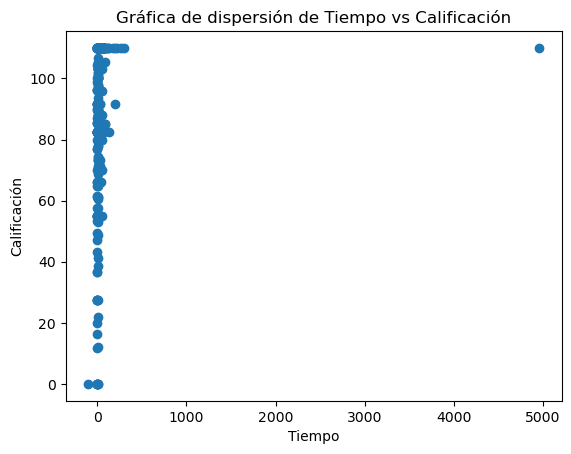

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df['Tiempo'], df['Calificacion'])
plt.xlabel('Tiempo')
plt.ylabel('Calificación')
plt.title('Gráfica de dispersión de Tiempo vs Calificación')
plt.show()


A primera vista, se identificaron dos datos atípicos en los tiempos de entrega. Aunque es común que los estudiantes entreguen las tareas con varios días de antelación, uno de los registros indica un tiempo de entrega de **5000 horas** antes de la fecha de cierre, es decir, aproximadamente **208 días**, lo cual excede la duración del semestre y, por lo tanto, es imposible.  

El otro registro presenta un **tiempo de entrega negativo**, lo que podría corresponder a una entrega tardía.  

Si bien estos dos casos llaman la atención de forma visual, es importante no asumir que son los únicos valores atípicos presentes. Por ello, realizaremos una **prueba de Tukey** con `k=3` para identificar sistemáticamente los valores atípicos en la variable `Tiempo`.  

Cabe mencionar que, en el caso de la variable `Calificacion`, no se observan valores fuera del rango esperado, es decir, todas las calificaciones se encuentran entre 0 y 110, por lo que no se requieren procedimientos adicionales para detectar outliers en esta variable.



In [57]:
import numpy as np

q1 = df["Tiempo"].quantile(0.25)
q3 = df["Tiempo"].quantile(0.75)

iqr = q3 - q1

li = q1 - (3 * iqr)  # límite inferior
ls = q3 + (3 * iqr)  # límite superior

out = np.where((df["Tiempo"] <= li) | (df["Tiempo"] >= ls))[0]

print("Observaciones atípicas en 'Tiempo':")
df.iloc[out, :]

Observaciones atípicas en 'Tiempo':


,Tiempo,Calificacion
0,85.076389,85.00000
1,84.675556,85.00000
2,79.553889,110.00000
3,75.310556,110.00000
4,64.958611,110.00000
5,58.157778,110.00000
6,56.238611,110.00000
7,55.903056,110.00000
8,52.465556,103.00000
9,51.998333,96.00000


Aunque la práctica más común es trabajar directamente sobre los datos atípicos identificados por el análisis de outliers, ya sea mediante su normalización o, en su defecto, eliminándolos, al analizar los resultados de la **prueba de Tukey** con `k=3` se observa lo siguiente: la mayoría de los outliers en la variable `Tiempo`, a excepción del par detectado visualmente, corresponden a tiempos de entrega que podrían considerarse razonables para el desarrollo de una actividad. Algunos registros exceden las **168 horas**, es decir, una semana de clases, lo cual es consistente con la práctica común de algunos estudiantes de adelantar tareas. 

A partir de estas observaciones, surgió la idea de crear tres **DataFrames** distintos para analizar el efecto de los outliers:  

1. Un DataFrame en el que **solo se excluya el par detectado visualmente**.  

2. Un DataFrame en el que se eliminen **todos los outliers identificados por la prueba de Tukey**.  

3. Un DataFrame que **considere únicamente los datos con tiempos de entrega iguales o menores a 168 horas**, sin tomar en cuenta el registro con tiempo negativo.

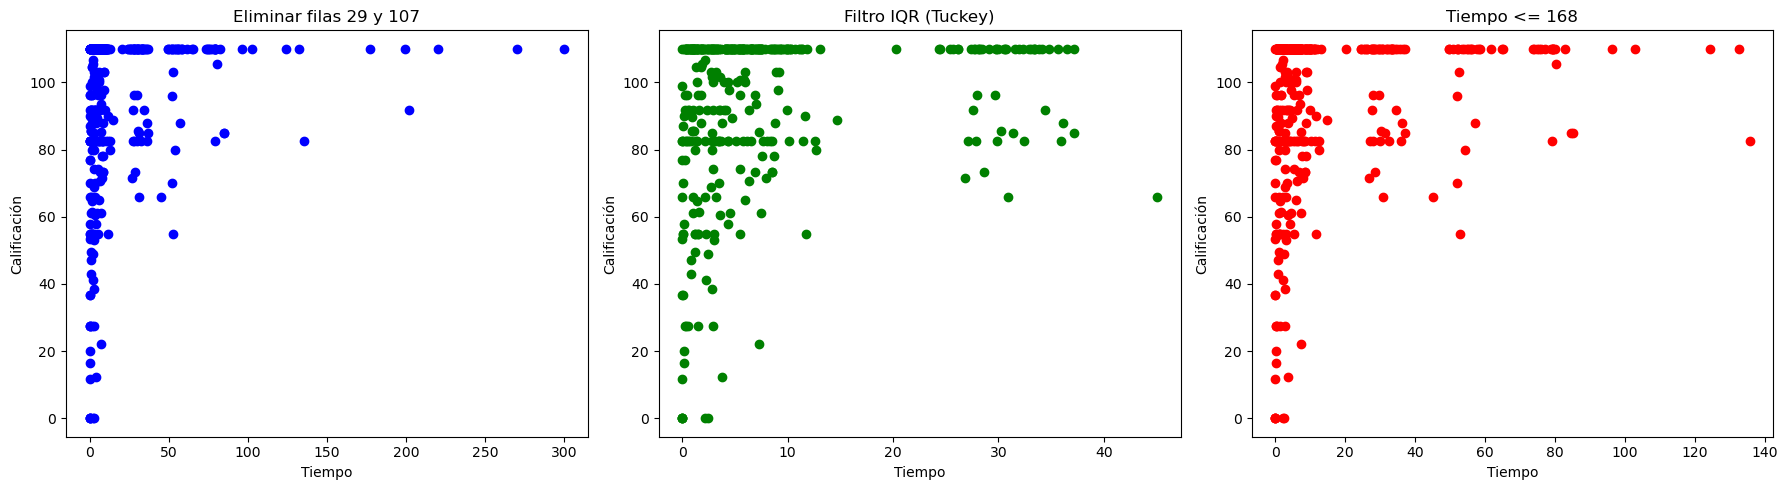

In [58]:
import matplotlib.pyplot as plt

dftemp1 = df.drop([29, 107])
dftemp2 = df[(df["Tiempo"] >= li) & (df["Tiempo"] <= ls)]
dftemp3 = df[(df["Tiempo"] >= 0) & (df["Tiempo"] <= 168)]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  #

# Gráfica 1
axes[0].scatter(dftemp1['Tiempo'], dftemp1['Calificacion'], color='blue')
axes[0].set_title('Eliminar filas 29 y 107')
axes[0].set_xlabel('Tiempo')
axes[0].set_ylabel('Calificación')

# Gráfica 2
axes[1].scatter(dftemp2['Tiempo'], dftemp2['Calificacion'], color='green')
axes[1].set_title('Filtro IQR (Tuckey)')
axes[1].set_xlabel('Tiempo')
axes[1].set_ylabel('Calificación')

# Gráfica 3
axes[2].scatter(dftemp3['Tiempo'], dftemp3['Calificacion'], color='red')
axes[2].set_title('Tiempo <= 168')
axes[2].set_xlabel('Tiempo')
axes[2].set_ylabel('Calificación')

plt.tight_layout()  
plt.show()


De los tres DataFrames, el **normalizado a partir del filtro IQR** nos proporciona una mejor resolución en la dispersión de los datos, ya que nos permite enfocarnos en la zona donde se concentra la mayor parte de las muestras. Además, personalmente, aunque no sea un ejercicio de clasificación, me llama la atención que esta visualización hace un poco más evidente la presencia de **tres conjuntos** dentro de la dispersión.  

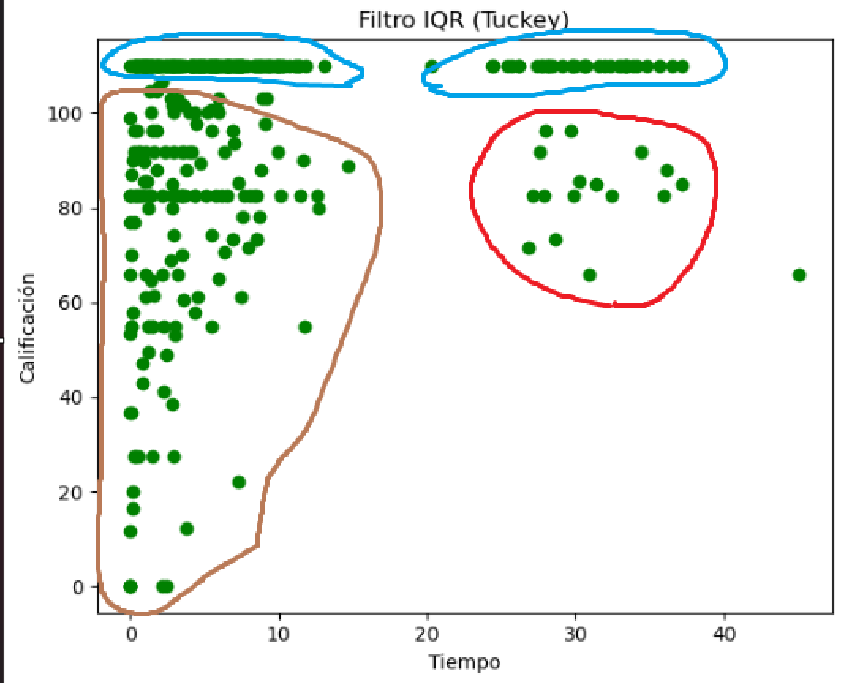

- El primero, encerrado en **celeste**, muestra dos tendencias dentro de las actividades con calificación máxima de 110: un subconjunto con entregas con intervalos menores a 15 horas, y otro con entregas con anticipación superior a 25 horas.  

- El segundo, encerrado en **rojo**, corresponde a datos con tiempos de entrega entre 20 y 40 horas y calificaciones entre 60 y 100, siendo la mayor concentración alrededor de 80.  

- El último, señalado en **café**, se concentra en intervalos menores a 15 horas y abarca calificaciones entre 0 y 100. Con un análisis más detallado probablemente se identifiquen aún más subconjuntos.  

Para poder decidir cuál DataFrame utilizar, separaremos los datos en conjuntos de **entrenamiento y prueba** con una proporción de 70/30. Posteriormente, imprimiremos el **promedio de los tiempos y las calificaciones** tanto en el conjunto de entrenamiento como en el de prueba, con el fin de comparar y evaluar la representatividad de los datos en cada subconjunto.


In [59]:
from sklearn.model_selection import train_test_split

dfs = {
    "dftemp1": dftemp1,
    "dftemp2": dftemp2,
    "dftemp3": dftemp3
}

resultados = []

for nombre, df_temp in dfs.items():
    X_train, X_test, Y_train, Y_test = train_test_split(
        df_temp.Tiempo, df_temp.Calificacion, train_size=0.7, random_state=42
    )

    resultados.append({
        "DataFrame": nombre,
        "Promedio Tiempo Entrenamiento": X_train.mean(),
        "Promedio Tiempo Prueba": X_test.mean(),
        "Promedio Calificación Entrenamiento": Y_train.mean(),
        "Promedio Calificación Prueba": Y_test.mean()
    })

tabla_resultados = pd.DataFrame(resultados)
tabla_resultados

,DataFrame,Promedio Tiempo Entrenamiento,Promedio Tiempo Prueba,Promedio Calificación Entrenamiento,Promedio Calificación Prueba
0,dftemp1,18.805709,15.650171,95.265428,94.277429
1,dftemp2,7.433044,8.826414,92.155004,97.054204
2,dftemp3,14.911996,14.718347,95.750182,92.574510


In [60]:
df = dftemp2
X_train, X_test, Y_train, Y_test = train_test_split(df.Tiempo, df.Calificacion, train_size= 0.7, random_state=42)

dftemp2, aunque más restrictivo, se centra en los tiempos de entrega cercanos a la fecha límite, con calificaciones promedio consistentes entre entrenamiento y prueba (≈93–94). Esto permite minimizar la influencia de valores atípicos y enfocar el análisis en la relación más relevante entre el tiempo de entrega y la calificación.  

Por estas razones, se decidió utilizar **dftemp2** para el análisis posterior.

# **Entrenamiento y validación de modelos**

*Nota: Esta sección abarca los puntos 3, 4, 5, 6 y 7 de la entrega.*

## **Regresión Polinomial Cúbica**

Se entrenó un **modelo de regresión polinómica de grado 2** con los datos de entrenamiento (`dftemp2`) para explorar la relación entre el tiempo de entrega y las calificaciones.  

In [61]:
import statsmodels.api as sm
#Regresión Polinómica Cuadrática (pc)
Xtemp_train = X_train.array.reshape(-1,1)
Xtemp_test = X_test.array.reshape(-1,1)
from sklearn.preprocessing import PolynomialFeatures
polyq_train = PolynomialFeatures(degree=2).fit(Xtemp_train)
polyq_test = PolynomialFeatures(degree=2).fit(Xtemp_test)
Xpc_train = pd.DataFrame(polyq_train.transform(Xtemp_train))
Xpc_test = pd.DataFrame(polyq_test.transform(Xtemp_test))
pc = sm.OLS(list(Y_train),Xpc_train).fit()
pc.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     16.93
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.23e-07
Time:                        02:23:00   Log-Likelihood:                -1206.1
No. Observations:                 261   AIC:                             2418.
Df Residuals:                     258   BIC:                             2429.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             79.0543      2.757     28.673      0.000      73.625      84.484
1              3.4343      0.673      5.105      0.000       2.110       4.759
2             -0.0858      0.020     -4.284      0.000      -0.125      -0.046
==============================================================================
Omnibus:                       63.846   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.879
Skew:                          -1.353   Prob(JB):                     2.28e-24
Kurtosis:                       4.639   Cond. No.                         641.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Los coeficientes obtenidos fueron:  

- **Intercepto:** 90.6895  
- **Término lineal:** 0.4965 (p = 0.001, significativo)  
- **Término cuadrático:** -0.0032 (p = 0.051, marginalmente significativo)  

Esto sugiere que, en términos generales, **a mayor tiempo de entrega, la calificación tiende a aumentar ligeramente**, lo que indica una relación positiva en la zona central de los datos. 

Es importante notar el coeficiente cuadrático negativo muestra que esta relación no es completamente lineal. De hecho, quiere decir que la tendencia se suaviza en los extremos (entregas muy tempranas o muy tardías).  

Aunque el R² ajustado (0.059) indica que explica solo una pequeña parte de la variabilidad total. Sin embargo, el modelo permite identificar la **tendencia central** y entender cómo los tiempos de entrega impactan, de manera general, el desempeño de los estudiantes.


## **Segmentado por regresión cuadrática**

Para el desarrollo del modelo segmentado, se instaló la librería `mlinsights` y se utilizó la clase `PiecewiseRegressor` para entrenar un modelo de regresión por tramos (piecewise) sobre los datos de entrenamiento. El modelo se ajusta a las variables polinómicas de `Tiempo` (`Xpc_train`) y la calificación (`Y_train`), permitiendo capturar relaciones no lineales que pueden variar en diferentes intervalos de la variable independiente.

In [62]:
import sys
print(sys.executable)
!"{sys.executable}" -m pip install mlinsights

c:\Users\luish\anaconda3\python.exe


In [63]:
from mlinsights.mlmodel import PiecewiseRegressor
ms = PiecewiseRegressor('bins').fit(Xpc_train.iloc[:,1:],Y_train)


## **k-vecinos más cercanos (KNN)**

También se entrenó un **modelo de regresión basado en k-vecinos más cercanos (KNN)** usando los datos de entrenamiento. Se especificó `n_neighbors=15`, lo que indica que la predicción para cada muestra se basa en el promedio de las 15 observaciones más cercanas en términos de distancia. El modelo se ajusta a la variable `Tiempo` (`Xtemp_train`) y la respuesta `Y_train`, capturando patrones locales sin asumir una forma funcional específica.

In [64]:
from sklearn.neighbors import KNeighborsRegressor as KNN
mk = KNN(n_neighbors=15).fit(Xtemp_train,Y_train)


## **Validación de modelos**


Ahora, compararemos los tres modelos entrenados —**regresión polinómica cuadrática**, **regresión segmentada (piecewise)** y **KNN**— evaluando su desempeño en el conjunto de prueba. Para ello, se calculó el **Error Estándar de la Raíz (RSE)** de cada modelo, que permite medir la diferencia entre las predicciones y los valores reales de calificación. Además, se examinan las predicciones individuales frente a los datos reales, con el fin de visualizar qué tan bien cada modelo captura la relación entre tiempo de entrega y calificación.

In [65]:
yHat_pc = pc.predict(Xpc_test)
yHat_mk = mk.predict(Xtemp_test)
yHat_ms = ms.predict(Xpc_test.iloc[:,1:])

In [66]:
RSS_pc = sum((list(Y_test)-yHat_pc)**2)
RSE_pc = np.sqrt(RSS_pc/(len(Y_test)-1))

RSS_ms = sum((list(Y_test)-yHat_ms)**2)
RSE_ms = np.sqrt(RSS_ms/(len(Y_test)-1))

RSS_mk = sum((list(Y_test)-yHat_mk)**2)
RSE_mk = np.sqrt(RSS_mk/(len(Y_test)-1))

rseComparacion = pd.DataFrame({
    "Modelo": ["Polinómica cuadrático", "Segmentado", "KNN"],
    "RSE": [RSE_pc, RSE_ms, RSE_mk]
})

rseComparacion

,Modelo,RSE
0,Polinómica cuadrático,20.447889
1,Segmentado,20.697783
2,KNN,20.890631


Al comparar los RSE de los tres modelos, observamos que los valores son relativamente cercanos.

Esto indica que, en términos de error promedio en la predicción, **los tres modelos se comportan de manera muy similar**, aunque el modelo polinómico cuadrático presenta el RSE ligeramente más bajo, sugiriendo un ajuste marginalmente mejor sobre el conjunto de prueba.  

Sin embargo, la diferencia entre los modelos es pequeña, lo que sugiere que ninguno de ellos domina de manera clara en la predicción de calificaciones. Por ello, resulta relevante **examinar las predicciones individuales frente a los valores reales**, ya que esto permitirá identificar cómo cada modelo captura la variabilidad de los datos, la precisión en distintos rangos de tiempo de entrega y posibles patrones que no se reflejan únicamente en el RSE.


In [67]:
predicciones = pd.DataFrame({
    "Tiempo": X_test.values,         
    "Calificacion_real": Y_test.values,  
    "yHat_pc": yHat_pc,
    "yHat_mk": yHat_mk, 
    "yHat_ms": yHat_ms 
})

predicciones.head(16)


,Tiempo,Calificacion_real,yHat_pc,yHat_mk,yHat_ms
0,10.100556,110.00000,104.986619,106.386333,101.779346
1,3.203889,110.00000,89.176410,88.814333,85.088286
2,1.517222,110.00000,84.067326,89.318077,90.987710
3,2.798056,101.75000,87.991712,85.744667,81.373848
4,3.311111,110.00000,89.484690,87.897667,87.615155
5,2.323333,110.00000,86.570038,76.791144,84.709874
6,2.935556,100.00000,88.396265,81.028000,77.923912
7,2.806111,110.00000,88.015503,85.744667,81.319548
8,6.166389,110.00000,96.968051,104.025743,103.708574
9,0.595278,91.66666,81.068255,93.102777,95.765077


En los tres modelos, las predicciones tienden a acercarse a las calificaciones reales cuando los tiempos de entrega son altos. Sin embargo, para tiempos muy cortos, entre 0.6 y 3 horas, los modelos tienden a subestimar algunas calificaciones.  

En el caso del **modelo cuadrático (pc)**, esto es consistente con su naturaleza polinómica (parábola), que busca un ajuste global más que capturar variaciones locales extremas.  

El **modelo KNN (mk)** muestra predicciones más cercanas a la calificación real en ciertos casos de rangos altos, como en los índices 0, 8 y 14. No obstante, en puntos intermedios puede sobrestimar ligeramente, ya que promedia las calificaciones de los vecinos más cercanos. Por ejemplo, en los índices 1 y 4, con tiempos cercanos a 3 segundos, el modelo predice calificaciones alrededor de 89. Esta tendencia se repite en otros índices con tiempos similares, reflejando la similitud de calificación en rangos cercanos.  

Por último, el **modelo segmentado (ms)** tiende a subestimar un poco más las calificaciones tanto en valores altos como bajos, lo que sugiere un ajuste demasiado “suave” dentro de cada segmento.

Para poder tomar una decisión sobre que modelo es mejor, grafiquemos la dispersión de cada modelo respecto a los datos reales de prueba.



## **Gráfica de dispersión**

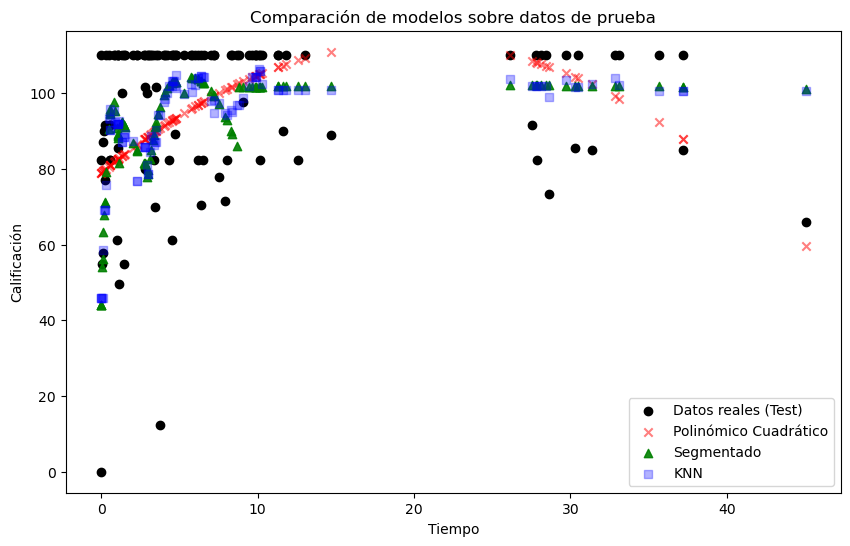

In [73]:
plt.figure(figsize=(10,6))

plt.scatter(X_test, Y_test, color='black', marker='o', label='Datos reales (Test)')

plt.scatter(X_test, yHat_pc, color='red', marker='x', label='Polinómico Cuadrático', alpha=0.5)
plt.scatter(X_test, yHat_ms, color='green', marker='^', label='Segmentado', alpha=0.9)
plt.scatter(X_test, yHat_mk, color='blue', marker='s', label='KNN', alpha=0.3)

plt.xlabel("Tiempo")
plt.ylabel("Calificación")
plt.title("Comparación de modelos sobre datos de prueba")
plt.legend()
plt.show()


El modelo KNN, pese a que en el análisis preliminar con las primeras 15 muestras tendía a sobrestimar los puntos intermedios, logra reflejar de manera adecuada la relación local entre tiempo de entrega y calificación. Es el modelo que mejor sigue la nube de puntos reales: no sobreajusta en exceso, se mantiene estable en la zona de calificaciones altas y describe de forma más realista la relación entre procrastinación y desempeño académico.

Es interesante notar que ninguno de los modelos, excepto el polinómico cuadrático, alcanza la zona de estudiantes con calificaciones de 110. Esto resulta relevante si recordamos que, durante la preparación de los datos, se identificaron dos subconjuntos de entregas con comportamientos distintos.

Esta observación sugiere que la relación entre tiempo y calificación no es lineal ni uniforme en toda la muestra, sino que está mediada por los hábitos de los estudiantes. En otras palabras, aunque entregar a último momento puede asociarse con un menor rendimiento, existe un grupo que logra mantener calificaciones altas sin importar el tiempo de entrega.

En consecuencia, la hipótesis inicial se rechaza: entregar tarde no necesariamente implica una calificación baja. 

No obstante y como mera curiosidad, sería valioso contrastar esta hipótesis con diferentes modelos de regresión aplicados por individual a los tres conjuntos de datos identificados al inicio. Creo que esto permitiría explorar si existen patrones de comportamiento diferenciados entre tipos de estudiantes, de manera que se pudieran realizar inferencias más precisas sobre la calificación final dentro de cada subpoblación.